# Baseline Model - Regime-Aware Volatility

We established:
- Log returns are approximately stationary
- Volatility clustering is present
- Market behavior is not structurally constant over long horizons

This notebook focus is on EWMA based volatility forecasting, and regime shift estimation. 

## Import Libraries

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# model
from arch import arch_model

In [89]:
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools

In [16]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

In [17]:
# fix runtime autoclose in collab
import ipykernel
ipykernel.version_info

(6, 29, 5)

## Data Prep

In [48]:
df = yf.download('MSFT', start='2014-01-01', auto_adjust=True, progress=False)
df.dropna(inplace=True)
df['LogReturn'] = np.log(df['Close']).diff()
print("are dates sorted?:", df.index.is_monotonic_increasing)

are dates sorted?: True


In [87]:
df_train, df_test = train_test_split(df, shuffle=False, train_size=0.7)

In [24]:
# is variance modeling actually needed?
std_resid = StandardScaler().fit_transform(df[['LogReturn']].dropna())
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid, nlags=12)
print("ARCH test on std resid p-value:", lm_pvalue)

ARCH test on std resid p-value: 2.1342122287979754e-112


ARCH LM null hypothesis assume all coffiecient including the constant is 0. 
p <<< 0.05 conforms that volatility clusters and varying conditional volatility.

## Model Building

In [56]:
r_pct = df['LogReturn'] * 100 # scaling for numeric stability 

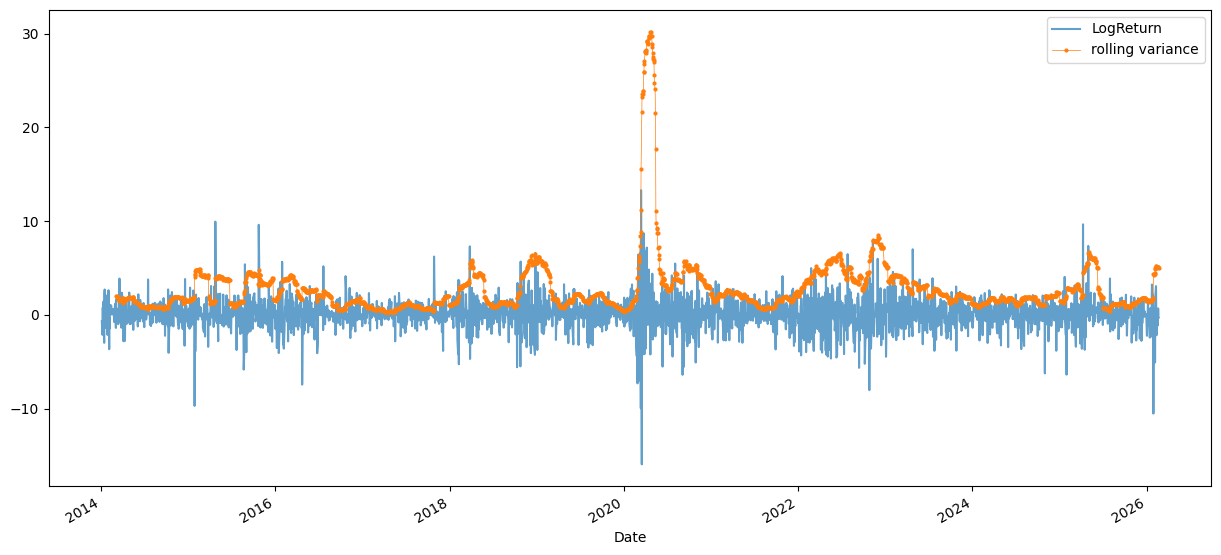

In [83]:
plt.figure(figsize=(15, 7))
(r_pct).plot(legend=True, alpha=0.7)
#(r_pct ** 2).plot(legend=True, label='variance')
(r_pct).rolling(42).var().plot(legend=True, label='rolling variance', 
                               marker='o', markersize=2, linewidth=0.5)
plt.show()

GARCH might perform better.

In [ ]:
target = 1 # volatility 1 day ahead

In [ ]:
r_pct = df['LogReturn'] * 100 # scaling for numeric stability 

for p, q in itertools.permutations([2, 5, 15], 2):
    arch_fit = arch_model(r_pct, mean="Zero", vol='ARCH', p=p, dist='normal').fit(disp='off')
    garch_fit = arch_model(r_pct, mean='Zero', vol='GARCH', p=p, q=q, dist='normal').f

2 5
2 15
5 2
5 15
15 2
15 5


In [ ]:
 
# ARCH(q): variance='ARCH'
arch1 = arch_model(r_pct, mean="Zero", vol="ARCH", p=1, dist="normal").fit(disp="off")
arch5 = arch_model(r_pct, mean="Zero", vol="ARCH", p=5, dist="normal").fit(disp="off")

# GARCH(p,q): variance='GARCH' where p is ARCH term, q is GARCH term
garch11 = arch_model(r_pct, mean="Zero", vol="GARCH", p=1, q=1, dist="normal").fit(disp="off")
garch21 = arch_model(r_pct, mean="Zero", vol="GARCH", p=2, q=1, dist="normal").fit(disp="off")
garch12 = arch_model(r_pct, mean="Zero", vol="GARCH", p=1, q=2, dist="normal").fit(disp="off")



                        Zero Mean - ARCH Model Results                        
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5737.97
Distribution:                  Normal   AIC:                           11479.9
Method:            Maximum Likelihood   BIC:                           11492.0
                                        No. Observations:                 3048
Date:                Wed, Feb 18 2026   Df Residuals:                     3048
Time:                        15:27:31   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.0355      0.141     14.468  1.927e-47 [  1.760,  2.31

In [20]:
models = {
    "ARCH(1)": arch1,
    "ARCH(5)": arch5,
    "GARCH(1,1)": garch11,
    "GARCH(2,1)": garch21,
    "GARCH(1,2)": garch12,
}

rows = []
for name, res in models.items():
    rows.append({
        "model": name,
        "aic": res.aic,
        "bic": res.bic,
        "loglik": res.loglikelihood
    })

pd.DataFrame(rows).sort_values("bic")


,model,aic,bic,loglik
2,"GARCH(1,1)",11196.888834,11214.955556,-5595.444417
3,"GARCH(2,1)",11198.603079,11222.692043,-5595.301539
4,"GARCH(1,2)",11198.888834,11222.977797,-5595.444417
1,ARCH(5),11215.982460,11252.115906,-5601.991230
0,ARCH(1),11479.932245,11491.976726,-5737.966122


The AIC BIC are very high, nowhere close to 1 - meaning the model are worse than 

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

def diag(res, lags=20):
    # standardized residuals
    z = res.std_resid.dropna()

    lb_z = acorr_ljungbox(z, lags=[lags], return_df=True)
    lb_z2 = acorr_ljungbox(z**2, lags=[lags], return_df=True)

    # Engle ARCH LM on standardized residuals
    arch_lm = het_arch(z, nlags=lags)  # returns (LM stat, LM pval, F stat, F pval)

    return {
        "LjungBox z pval": float(lb_z["lb_pvalue"].iloc[0]),
        "LjungBox z^2 pval": float(lb_z2["lb_pvalue"].iloc[0]),
        "ARCH LM pval": float(arch_lm[1]),
    }

for name, res in models.items():
    print(name, diag(res, lags=20))


ARCH(1) {'LjungBox z pval': 0.0029704815872935724, 'LjungBox z^2 pval': 1.5517298895162623e-22, 'ARCH LM pval': 7.236779217405447e-13}
ARCH(5) {'LjungBox z pval': 0.19550989642853417, 'LjungBox z^2 pval': 0.7430591912940578, 'ARCH LM pval': 0.7265308526823129}
GARCH(1,1) {'LjungBox z pval': 0.24863951971446263, 'LjungBox z^2 pval': 0.9516727893896644, 'ARCH LM pval': 0.9459375199136096}
GARCH(2,1) {'LjungBox z pval': 0.24840355584553622, 'LjungBox z^2 pval': 0.9474372790460498, 'ARCH LM pval': 0.9428114212632708}
GARCH(1,2) {'LjungBox z pval': 0.24864236943226012, 'LjungBox z^2 pval': 0.951669493555462, 'ARCH LM pval': 0.9459316178443711}
